## Endeví de resultats

Aquest codi inclou un model de Deep Learning per predir els resultats d'un partit a partir de les dades històriques de partits.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import joblib

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Per poder entrenar el model, ens cal donar-li informació de qui està jugant (amb quins punts forts i punts febles) i quin és el resultat. Per tant, hem de llegir el fitxer amb les estadístiques de cada jugador i també el fitxer amb el registre històric de resultats.

In [2]:
# Llegim l'històric de partits i resultats
matches_df = pd.read_csv('results.csv')
matches_df

,D,Jugador 1,Jugador 2,Jugador 3,Jugador 4,Gols 1,Gols 2,Gols 3,Gols 4,Local,Visitant,Guanyador
0,1,Dani,Luis,Antía,Guille,2,1,0,2,3,2,Local
1,1,Guille,Dani,Luis,Antía,1,2,1,1,3,2,Local
2,1,Guille,Luis,Antía,Dani,0,2,1,2,2,3,Visitant
3,1,Antía,Guille,Luis,Dani,0,0,0,3,0,3,Visitant
4,1,Antía,Dani,Guille,Luis,0,3,2,0,3,2,Local
...,...,...,...,...,...,...,...,...,...,...,...,...
262,45,Rebeca,Luis,Antía,Pau,1,1,0,3,2,3,Visitant
263,46,Antía,Rebeca,Guille,Luis,2,1,1,0,3,1,Local
264,46,Antía,Rebeca,Guille,Luis,2,0,2,1,2,3,Visitant
265,46,Antía,Guille,Luis,Rebeca,1,0,1,2,1,3,Visitant


In [3]:
# Llegim les estadístiques de cada jugador
stats_xr = xr.open_dataset('stats.nc', engine='scipy')
stats_xr

<xarray.Dataset> Size: 116kB
Dimensions:                (matchday: 46, player: 17)
Coordinates:
  * matchday               (matchday) int32 184B 0 1 2 3 4 5 ... 41 42 43 44 45
  * player                 (player) object 136B 'Alejandro' 'Antía' ... 'Víctor'
Data variables: (12/23)
    GamesPlayed            (matchday, player) int32 3kB ...
    PlayedAttack           (matchday, player) int32 3kB ...
    PlayedDefense          (matchday, player) int32 3kB ...
    WinPlayed              (matchday, player) float64 6kB ...
    WinPlayedAttack        (matchday, player) float64 6kB ...
    WinPlayedDefense       (matchday, player) float64 6kB ...
    ...                     ...
    ReceivedDefensePlayed  (matchday, player) float64 6kB ...
    ELOAttack              (matchday, player) float64 6kB ...
    ELODefense             (matchday, player) float64 6kB ...
    AttackIndex            (matchday, player) float64 6kB ...
    DefenseIndex           (matchday, player) float64 6kB ...
    WeightedELO            (matchday, player) float64 6kB ...

Construïm una matriu amb els paràmetres dels jugadors a pista (matriu `X`) i una matriu amb el resultat (matriu `y`). La matriu `y` l'extraiem directament de `matches_df`. La matriu `X` la construïm a partir dels jugadors que són a pista a cada partit (de `matches_df`) i les estadístiques de `stats_xr`.

Ens cal codificar els resultats. Els possibles resultats són 6: '3-0', '3-1', '3-2', '0-3', '1-3', '2-3'. Perquè el model pugui treballar bé, passarem aquests possibles valors a codis (0, 1, 2, 3, 4, 5), a partir dels quals en farem l'entrenament. Per usos futurs, també codificarem el guanyador (local/vistant).

In [4]:
encoder_winning = preprocessing.LabelEncoder() # codificador d'etiquetes ('Local'/'Visitant') a nombres (0/1)
Results_winning_training = encoder_winning.fit_transform(matches_df['Guanyador'].values.astype(str))

# Array amb tots els resultats que farem servir per l'entrenament del model (0='Local', 1='Visitant')
Results_winning_training

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1], dtype=int64)

In [5]:
# El mateix que abans, però per tots els possibles resultats
# Llista amb tots els resultats en format unificat (6 resultats possibles)
Scores = [str(matches_df['Local'].iloc[i])+'-'+str(matches_df['Visitant'].iloc[i]) for i in range(matches_df.shape[0])]
Scores = np.array(Scores)

# Codifiquem els resultats (0-3: 0, 1-3: 1, ..., 3-2:5)
encoder_scores = preprocessing.LabelEncoder()
Scores_training = encoder_scores.fit_transform(Scores.astype(str))

# Desem l'StandardScaler() per fer-lo servir en un altre programa
joblib.dump(encoder_scores, 'encoder_scores.pkl')

Scores_training

array([5, 5, 2, 0, 5, 1, 4, 0, 5, 1, 5, 0, 2, 5, 1, 4, 1, 5, 4, 0, 3, 1,
       4, 2, 5, 1, 1, 2, 0, 5, 5, 0, 2, 2, 5, 5, 1, 5, 1, 0, 0, 2, 2, 2,
       4, 3, 5, 2, 2, 3, 3, 3, 1, 0, 5, 0, 4, 2, 3, 2, 1, 2, 5, 2, 4, 0,
       4, 5, 2, 3, 4, 3, 3, 4, 3, 4, 4, 4, 1, 4, 3, 0, 2, 5, 1, 0, 1, 1,
       5, 1, 1, 5, 1, 4, 1, 1, 0, 2, 1, 4, 4, 2, 5, 5, 2, 4, 5, 3, 4, 1,
       2, 2, 4, 3, 2, 5, 2, 5, 3, 4, 4, 2, 1, 5, 0, 1, 1, 0, 4, 0, 2, 4,
       1, 4, 3, 2, 1, 2, 3, 5, 1, 5, 3, 4, 2, 3, 3, 4, 0, 2, 1, 2, 1, 1,
       1, 5, 0, 0, 3, 1, 3, 5, 5, 2, 1, 5, 0, 1, 0, 5, 0, 4, 4, 5, 2, 4,
       0, 1, 0, 5, 5, 0, 4, 1, 4, 5, 2, 4, 2, 5, 5, 2, 5, 0, 4, 2, 4, 4,
       3, 1, 5, 2, 1, 2, 1, 2, 4, 2, 4, 1, 2, 4, 3, 3, 3, 4, 4, 4, 4, 4,
       5, 0, 2, 0, 2, 1, 5, 1, 1, 5, 4, 1, 2, 0, 5, 4, 5, 5, 4, 0, 1, 2,
       4, 0, 1, 0, 3, 2, 3, 2, 0, 5, 5, 3, 0, 0, 2, 4, 4, 5, 1, 2, 2, 4,
       2, 1, 1], dtype=int64)

Seguidament construïm la matriu `X` que conté les dades dels jugadors al camp. Primer definim quins paràmetres tenim en compte pels atacants i pels defensors. Després, construïm la matriu on, fila per fila, hi ha tots els paràmetres dels jugadors.

In [6]:
# Paràmetres que considerem al model, en funció de si el jugador és atacant o defensor
considered_stats_defense = ['GamesPlayed', 'WeightedELO', 'PlayedDefense', 'WinPlayedDefense', 'ScoredDefensePlayed', 'ReceivedDefensePlayed', 'ELODefense', 'DefenseIndex']
considered_stats_attack = ['GamesPlayed', 'WeightedELO', 'PlayedAttack', 'WinPlayedAttack', 'ScoredAttackPlayed', 'ReceivedAttackPlayed', 'ELOAttack', 'AttackIndex']

# Dataframe on hi desem tots els paràmetres d'avaluació de cada jugador
columns = [stat_def+'1' for stat_def in considered_stats_defense] + [stat_att+'2' for stat_att in considered_stats_attack] +\
            [stat_def+'3' for stat_def in considered_stats_defense] + [stat_att+'4' for stat_att in considered_stats_attack] # noms de les columnes
Stats_training = pd.DataFrame(columns = columns)

for nmatch in range(len(matches_df['D'])): # per cada partit disputat
    match_df = matches_df.iloc[nmatch] # triem les dades d'aquest partit

    matchday = match_df['D']-1 # número de matchday
    
    # Llista on hi desarem els valors des les estadístiques de cada jugador que hi ha al camp, amb el mateix ordre que `columns`
    stats_match = []
    for player in match_df[['Jugador 1', 'Jugador 2', 'Jugador 3', 'Jugador 4']]:
        if (player == match_df['Jugador 1']) or (player == match_df['Jugador 3']): # defensors
            # Triem les estadístiques dels jugadors en aquest partit
            player_stats = stats_xr.sel(matchday=matchday, player=player)[considered_stats_defense].to_array().values
        elif (player == match_df['Jugador 2']) or (player == match_df['Jugador 4']): # atacants
            # Triem les estadístiques dels jugadors en aquest partit
            player_stats = stats_xr.sel(matchday=matchday, player=player)[considered_stats_attack].to_array().values
        stats_match = stats_match + list(player_stats) # adjuntem les estadístiques del jugador a les dades d'aquest partit
    # Desem la llista d'estadístiques d'aquest partit
    Stats_training.loc[len(Stats_training)] = stats_match
    
Stats_training

,GamesPlayed1,WeightedELO1,PlayedDefense1,WinPlayedDefense1,ScoredDefensePlayed1,ReceivedDefensePlayed1,ELODefense1,DefenseIndex1,GamesPlayed2,WeightedELO2,...,ELODefense3,DefenseIndex3,GamesPlayed4,WeightedELO4,PlayedAttack4,WinPlayedAttack4,ScoredAttackPlayed4,ReceivedAttackPlayed4,ELOAttack4,AttackIndex4
0,6.0,1041.417153,1.0,1.000000,2.000000,2.000000,1008.478261,6.166667,6.0,990.403188,...,984.781760,1.333333,6.0,991.670245,2.0,0.000000,1.000000,3.000000,987.228702,2.666667
1,6.0,991.670245,4.0,0.500000,0.750000,2.250000,993.891016,4.000000,6.0,1041.417153,...,997.821096,7.666667,6.0,986.168133,1.0,0.000000,1.000000,3.000000,993.100000,1.000000
2,6.0,991.670245,4.0,0.500000,0.750000,2.250000,993.891016,4.000000,6.0,990.403188,...,984.781760,1.333333,6.0,1041.417153,5.0,1.000000,2.600000,1.400000,1048.004932,11.166667
3,6.0,986.168133,5.0,0.400000,0.200000,2.600000,984.781760,1.333333,6.0,991.670245,...,997.821096,7.666667,6.0,1041.417153,5.0,1.000000,2.600000,1.400000,1048.004932,11.166667
4,6.0,986.168133,5.0,0.400000,0.200000,2.600000,984.781760,1.333333,6.0,1041.417153,...,993.891016,4.000000,6.0,990.403188,4.0,0.250000,1.000000,2.750000,986.694233,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,57.0,897.605027,33.0,0.212121,0.333333,2.575758,864.203532,29.947368,165.0,993.787945,...,1093.919811,94.684211,121.0,1117.645270,72.0,0.625000,1.569444,1.583333,1170.332194,91.132231
263,156.0,1046.320329,107.0,0.616822,0.878505,1.785047,1083.114274,98.397436,61.0,899.624520,...,1005.892810,75.750000,169.0,996.784919,143.0,0.482517,1.174825,2.083916,1009.654263,143.846154
264,156.0,1046.320329,107.0,0.616822,0.878505,1.785047,1083.114274,98.397436,61.0,899.624520,...,1005.892810,75.750000,169.0,996.784919,143.0,0.482517,1.174825,2.083916,1009.654263,143.846154
265,156.0,1046.320329,107.0,0.616822,0.878505,1.785047,1083.114274,98.397436,120.0,978.908914,...,926.003526,253.846154,61.0,899.624520,28.0,0.357143,0.392857,2.285714,941.370684,11.000000


Ara ja tenim les dades `X` per entrenar el model. Abans d'entrenar-lo, estandaritzem els valors. Això és un pas comú en IA quan es tenen paràmetres amb diferents escales de valors.

In [7]:
scaler = preprocessing.StandardScaler()
Stats_training_stand = scaler.fit(Stats_training).transform(Stats_training.astype(float))

In [8]:
# Desem l'StandardScaler() per fer-lo servir en un altre programa
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Separem tots els partits que tenim en una mostra d'entrenament (train) i una mostra de test. Això ens permetrà avaluar el rendiment del nostre model. En aquest cas, de la mostra total un 10% serà de test i el 90% restant serà per entrenar el model.

In [9]:
X_train, X_test, y_winning_train, y_winning_test, y_score_train, y_score_test = train_test_split(Stats_training_stand, Results_winning_training, Scores_training, test_size=0.2) # random_state=42

In [10]:
# Passem els valors y al codi numèric
y_score_train_labels = encoder_scores.inverse_transform(y_score_train)
y_score_test_labels = encoder_scores.inverse_transform(y_score_test)

y_winning_train_labels = encoder_winning.inverse_transform(y_winning_train)
y_winning_test_labels = encoder_winning.inverse_transform(y_winning_test)

## Definició i entrenament del model

El model de xarxa neuronal (Deep Learning) el crearem amb Keras, dins de TensorFlow. Primer crearem el model, l'entrenarem i després l'avaluarem.

#### Model de predicció de l'equip guanyador

Aquest model és una xarxa sequencial (una capa darrere l'altra) que acaba amb una funció d'activació softmax. Aquesta funció d'activació la interpretem com la probabilitat que ocorri cada possible resultat (3-0, 3-1, 3-2...). L'arquitectura del model (quines capes té i amb quina dimensionalitat) és de tria arbitrària.

In [11]:
# Definim el model keras
input_layer = layers.Input(shape = (X_train.shape[1],)) # capa d'input
x = layers.Dense(32, activation = 'relu')(input_layer) # capes internes
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dense(8, activation = 'relu')(x)
x = layers.Dense(4, activation = 'relu')(x)
x = layers.Dense(2, activation = 'relu')(x)

score_output = layers.Dense(6, activation  = 'softmax', name='score_output')(x) # probabilitat associada a cada resultat

# Agrupem totes les capes
model = models.Model(inputs=input_layer, outputs=[score_output])

# Resum del model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ score_output (Dense)                 │ (None, 6)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,056 (8.03 KB)

 Trainable params: 2,056 (8.03 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compilem el model. Definim quina funció de cost fem servir, l'optimitzador i les mètriques que fem servir per avaluar-lo
model.compile(optimizer='adam', loss={
            'score_output': 'sparse_categorical_crossentropy'
            },
              metrics={
                  'score_output': ['accuracy']
              }
             )

In [13]:
# Entrenem el model. Definim quantes èpoques fem servir i la mida batch
model.fit(X_train, y_score_train,
          validation_data = (X_test, y_score_test),
          epochs=500, batch_size = 10, verbose=False) # PER FER: DEFINIR UN CALLBACK QUE ATURI L'ENTRENAMENT FINS UQE S'ARRIBI A UN LOSS DETERMINAT

### Avaluació del model

A continuació es fan una sèrie d'avaluacions per comprovar que el model funciona correctament. Numèricament, extraurem la precisió del model. Visualment, dibuixarem les matrius de confusió, que ens indiquen quins són els punts forts i els punts febles del model.

In [14]:
# Avaluem el model amb els valors de test (extracte de les mètriques del model)
results = model.evaluate(
    X_test,
    y_score_test)

# Desem els resultats de les mètriques de cada paràmetre avaluat (marcador i equip guanyador) com un diccionari
metrics = dict(zip(model.metrics_names, results))

print("Total loss:", metrics['loss'])
print("Compile_metrics", metrics['compile_metrics'])
#print("Winner accuracy:", metrics['winner_output_accuracy'])
#print("Score accuracy:", metrics['score_output_accuracy'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2562 - loss: 13.2938
Total loss: 16.123184204101562
Compile_metrics 0.25925925374031067


A continuació treurem les llistes de valors que ens permeten avaluar-ne la precisió.

In [15]:
# Treiem la predicció per cada cas d'input (amb els valors train)
score_pred = model.predict(X_train)
score_pred_class = score_pred.argmax(axis = 1) # triem quin és el resultat que és la probabilitat més alta

# Passem el codi numèric a etiquetes amb els marcadors dels partits
score_pred_labels = encoder_scores.inverse_transform(score_pred_class)
#predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 


In [16]:
# Conjunt de paràmetres que avaluen el model
print(classification_report(y_score_train, score_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87        29
           1       0.86      0.79      0.82        38
           2       0.77      0.88      0.82        41
           3       1.00      0.74      0.85        23
           4       0.81      0.74      0.77        46
           5       0.67      0.89      0.76        36

    accuracy                           0.81       213
   macro avg       0.84      0.80      0.82       213
weighted avg       0.83      0.81      0.81       213



In [17]:
# En funció del resultat predit, trobem quin equip es prediu que guanya
winner_labels = []
for i in range(len(score_pred_labels)):
    local, visitant = score_pred_labels[i].split('-')
    if local > visitant:
        winner_label = 'Local'
    else:
        winner_label = 'Visitant'
    winner_labels.append(winner_label)

winner_labels = np.array(winner_labels)
winner_labels_encoded = encoder_winning.transform(winner_labels)
winner_labels_encoded

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])

In [18]:
# Precisió de la predicció. Comparem els marcadors predits (score_pred_class) i els marcadors reals (y_score_test)
print("Accuracy in score:", accuracy_score(y_score_train, score_pred_class) * 100, "%")

Accuracy in score: 80.75117370892019 %


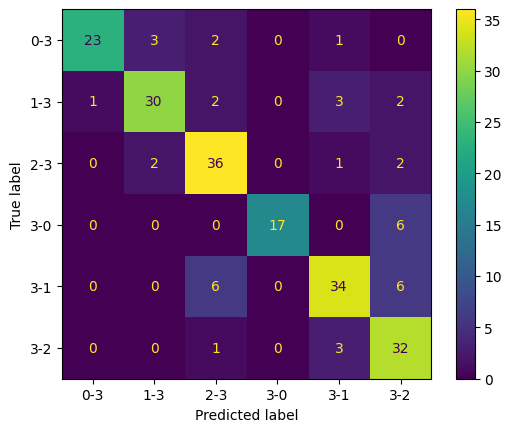

In [19]:
# Imprimim la matriu de confusió, que ens indica els punts forts i punts febles del model
ConfusionMatrixDisplay.from_predictions(y_score_train_labels, score_pred_labels)

In [20]:
# Precisió de la predicció. Comparem els marcadors predits (score_pred_class) i els marcadors reals (y_score_test)
print("Accuracy in winning team:", accuracy_score(y_winning_train, winner_labels_encoded) * 100, "%")

Accuracy in winning team: 92.48826291079813 %


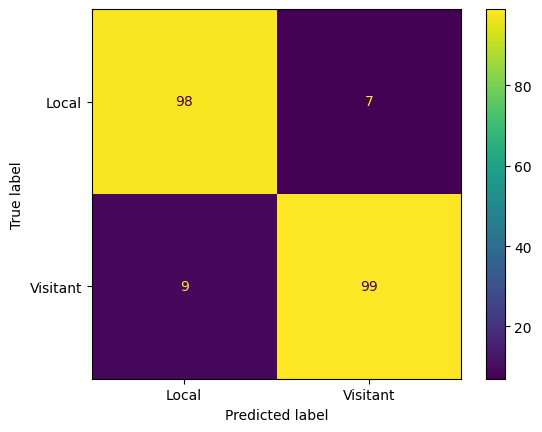

In [21]:
# Imprimim la matriu de confusió, que ens indica els punts forts i punts febles del model
ConfusionMatrixDisplay.from_predictions(encoder_winning.inverse_transform(y_winning_train), winner_labels)

In [22]:
# Desem el model i els pesos
model.save('sequential.keras')